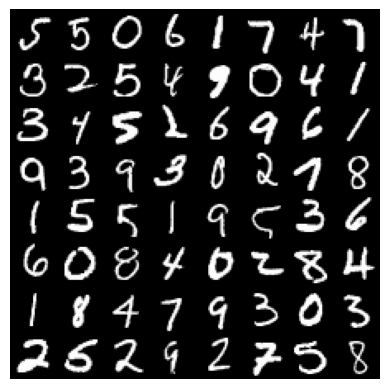

In [2]:
tfms = x_transform_mnist()
ds = torchvision.datasets.MNIST('./data/mnist/', download=True, transform=tfms)
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True, num_workers=0)
b = next(iter(dl))
show_batch_images(b[0])

In [1]:
import glob
import re
import os
import numpy as np
from torch.utils.data import Dataset
import torch
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import PIL
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim



from src.datasets import sigcomp2009, mnist, cedar
from src.pair_dataset import *
from src.visualization import *
from src.tools import *
from src.models import *
from src.train import *

In [2]:
ds_train = sigcomp2009(train=True)
ds_valid = sigcomp2009(train=False)
len(ds_train), len(ds_valid)

(940, 60)

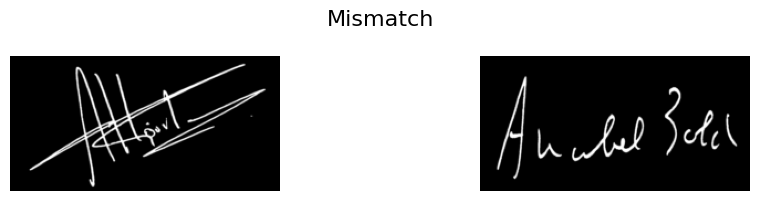

In [3]:
tfms = x_transform_signatures()
pds_train = PairDataset(ds_train, x_transform=tfms, y_transform=y_transform_category(ds_train))
pds_valid = PairDataset(ds_valid, x_transform=tfms, y_transform=y_transform_category(ds_valid))
x=pds_train[0]
show_pair(x)

In [ ]:
ds_train = sigcomp2009(train=True)
ds_valid = sigcomp2009(train=False)
len(ds_train), len(ds_valid)

In [ ]:
tfms = x_transform_signatures()
pds_train = PairDataset(ds_train, x_transform=tfms, y_transform=y_transform_category(ds_train))
pds_valid = PairDataset(ds_valid, x_transform=tfms, y_transform=y_transform_category(ds_valid))
x=pds_train[0]
show_pair(x)

In [4]:
model=SiamessClassifier().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
opt = optim.AdamW(model.parameters(), lr=lr, eps=adam_eps)

In [5]:
dl_train = torch.utils.data.DataLoader(pds_train, batch_size=32, shuffle=True, num_workers=0)
dl_valid = torch.utils.data.DataLoader(pds_valid, batch_size=64, shuffle=False, num_workers=0)

In [12]:
class SiamessClassifier(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.criterion = torch.nn.BCEWithLogitsLoss()
        
        self.cls = torch.nn.Sequential(
            #torch.nn.Dropout(p=0.5),
            torch.nn.Linear(512,256),
            torch.nn.ReLU(),
            #torch.nn.Dropout(p=0.5),
            torch.nn.Linear(256,1),
        )
        
        self.encoder = torch.nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            resnet.avgpool,
            torch.nn.Flatten(),
        )

    def forward(self, x1,x2, y1, y2):
        f1 = self.encoder(x1)
        f2 = self.encoder(x2)
        logits = self.cls(f1-f2).squeeze(1)
        labels = (y1==y2).float()
        loss = self.criterion(logits, labels)
        return f1, f2, labels, logits, loss

model=SiamessClassifier().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
opt = optim.AdamW(model.parameters(), lr=lr, eps=adam_eps)

In [13]:
training_epoch(model, opt, dl_train, device)

Training epoch [1/1]: 100%|█████████████████████| 59/59 [00:42<00:00,  1.39it/s]

Epoch [1/1], Training loss: 0.5980


In [14]:
for _ in range(5):
    training_epoch(model, opt, dl_train, device)

Training epoch [1/1]: 100%|█████████████████████| 59/59 [00:41<00:00,  1.41it/s]


Epoch [1/1], Training loss: 0.4950


Training epoch [1/1]: 100%|█████████████████████| 59/59 [00:42<00:00,  1.38it/s]


Epoch [1/1], Training loss: 0.4502


Training epoch [1/1]: 100%|█████████████████████| 59/59 [00:43<00:00,  1.36it/s]


Epoch [1/1], Training loss: 0.4325


Training epoch [1/1]: 100%|█████████████████████| 59/59 [00:43<00:00,  1.37it/s]


Epoch [1/1], Training loss: 0.3940


Training epoch [1/1]: 100%|█████████████████████| 59/59 [00:54<00:00,  1.09it/s]

Epoch [1/1], Training loss: 0.3606


In [17]:
def valid_epoch(model, opt, dl, device, n_epoch = 0, num_epochs = 1):
    model.eval()
    val_loss = 0.0
    all_logits = []
    with torch.no_grad():
        for x1, x2, y1, y2 in tqdm.tqdm(dl, desc=f'Valid epoch [{n_epoch + 1}/{num_epochs}]'):
            x1, x2, y1, y2 = x1.to(device), x2.to(device), y1.to(device, dtype=torch.float32), y2.to(device, dtype=torch.float32)
            B = x1.size(0)
            logits, loss = model(x1, x2, y1, y2)[-2:]
            all_logits.append(logits)
            val_loss += loss.item()*B
    all_logits = torch.concat(all_logits)
    avg_val_loss = val_loss / len(dl.dataset)
    accuracy = (all_logits>0.5).float().mean().item()
    print(f"Epoch [{n_epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

valid_epoch(model, opt, dl_valid, device)

Valid epoch [1/1]: 100%|██████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

Epoch [1/1], Validation Loss: 0.3428, Accuracy: 0.49%


In [72]:
l=next(iter(dl_train))
l[0],l[1],l[2],l[3] =l[0].to(device),l[1].to(device),l[2].to(device),l[3].to(device)
[x.shape for x in l]

[torch.Size([64, 3, 122, 244]),
 torch.Size([64, 3, 122, 244]),
 torch.Size([64]),
 torch.Size([64])]

In [77]:
class Siamess_ResNet18_NNDistance(torch.nn.Module):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        #self.resnet.fc=nn.Identity()
        #self.encoder = torch.nn.Flatten()
        #self.head = torch.nn.Sequential(torch.nn.Linear(2352,200),nn.ReLU(inplace=True), torch.nn.Linear(200,1))
        self.head = torch.nn.Sequential(torch.nn.Linear(1024,1))
        self.criterion = torch.nn.BCEWithLogitsLoss()
        
        self.encoder = torch.nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            #resnet.avgpool,
            #torch.nn.Flatten(),
        )
        #self.transformer = nn.Transformer(d_model=512)
        

    def forward(self, x1, x2, y1, y2):
        f1 = self.encoder(x1)
        f2 = self.encoder(x2)
        #fts = torch.concat([f1,f2],dim=1)
        #fts = f1-f2
        print(f1.view(64,512,-1).permute(0,2,1).shape)
        return f1, f2
        #logits = self.head(fts)
        #logits = logits.squeeze(1)
        #print(labels.mean())
        labels = (y1==y2).float()
        labels = (y1==y2).float()
        logits = self.head(torch.concat([f1,f2],dim=1)).squeeze(1)
        return f1, f2, labels, logits, self.criterion(logits, labels)
        

# Instantiate and test the modified model
model = Siamess_ResNet18_NNDistance()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    print(model(l[0],l[1],l[2],l[3].float()))

torch.Size([64, 32, 512])
tensor([[[[0.0000e+00, 0.0000e+00, 3.7332e-01,  ..., 6.2999e+00,
           3.5755e+00, 2.3760e-01],
          [0.0000e+00, 0.0000e+00, 7.8855e-01,  ..., 6.7950e+00,
           3.7878e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.0804e+00,  ..., 3.2755e+00,
           1.2030e+00, 0.0000e+00],
          [3.4341e-01, 0.0000e+00, 1.0192e+00,  ..., 9.7972e-01,
           7.1827e-02, 0.0000e+00]],

         [[0.0000e+00, 3.0802e-01, 7.8874e-01,  ..., 4.3699e+00,
           2.1641e+00, 5.2633e-01],
          [0.0000e+00, 9.4653e-01, 1.0588e+00,  ..., 5.6221e+00,
           2.8875e+00, 0.0000e+00],
          [8.2128e-01, 2.6359e+00, 3.4093e+00,  ..., 4.0566e+00,
           1.6096e+00, 0.0000e+00],
          [1.1112e+00, 1.9206e+00, 2.0360e+00,  ..., 5.1541e-01,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+

In [80]:
transformer = nn.Transformer(d_model=512)

In [81]:
with torch.no_grad():
    src = torch.rand((10, 32, 512))
    tgt = torch.rand((10, 32, 512))
    x = transformer(src, tgt)
    print(x.shape)

torch.Size([10, 32, 512])


In [29]:


for x in range(5):
    training_epoch(model, opt, dl_train, device)

Training epoch [1/1]: 100%|███████████████████| 313/313 [00:20<00:00, 14.95it/s]


Epoch [1/1], Training loss: 0.7858


Training epoch [1/1]: 100%|███████████████████| 313/313 [00:20<00:00, 14.98it/s]


Epoch [1/1], Training loss: 0.7803


Training epoch [1/1]: 100%|███████████████████| 313/313 [00:20<00:00, 15.05it/s]


Epoch [1/1], Training loss: 0.7859


Training epoch [1/1]: 100%|███████████████████| 313/313 [00:20<00:00, 15.14it/s]


Epoch [1/1], Training loss: 0.7870


Training epoch [1/1]: 100%|███████████████████| 313/313 [00:20<00:00, 14.97it/s]

Epoch [1/1], Training loss: 0.7856


In [ ]:
opt = optim.AdamW(model.cls.parameters(), lr=5e-4, eps=1e-5)

In [23]:
opt = optim.AdamW(model.parameters(), lr=5e-4, eps=1e-5)

Training epoch [1/1]:  44%|█████████▏           | 14/32 [00:00<00:00, 75.88it/s]

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


Training epoch [1/1]: 100%|█████████████████████| 32/32 [00:00<00:00, 87.91it/s]

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
Epoch [1/1], Training loss: 0.7258


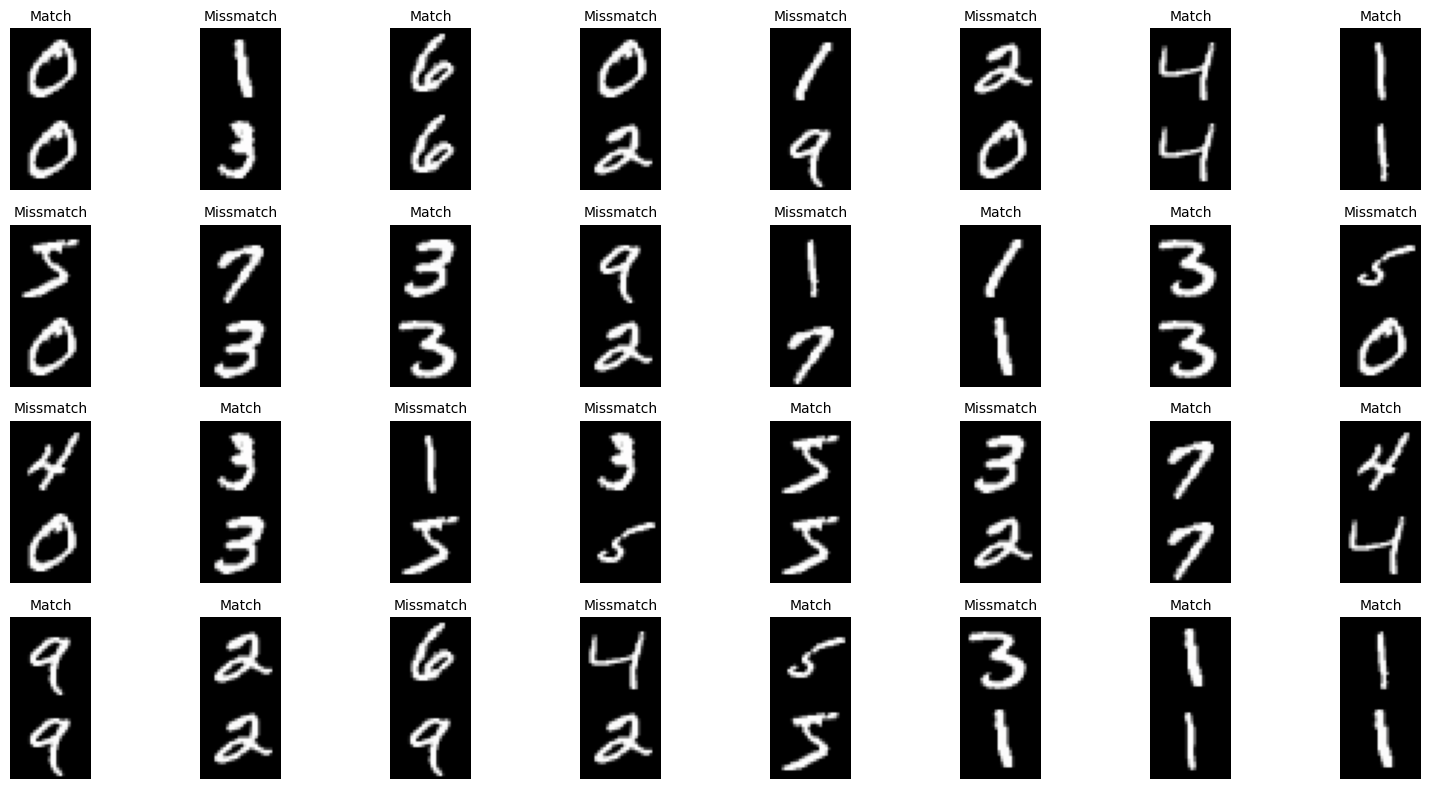

In [13]:
show_pair_batch(*l)

In [31]:
def valid_metrics(model, dl, device, n_epoch = 0, num_epochs = 1):
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x1, x2, labels in tqdm.tqdm(dl, desc=f'Valid epoch [{n_epoch + 1}/{num_epochs}]'):
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device, dtype=torch.float32)
            logits, loss = model(x1, x2, labels)[-2:]
            val_loss += loss.item()
            predictions = (logits >= 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate and print the average validation loss and accuracy per epoch
    avg_val_loss = val_loss / len(dl.dataset)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch [{n_epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

valid_metrics(model,dl_train,device)


        
        

Valid epoch [1/1]: 100%|████████████████████████| 59/59 [00:28<00:00,  2.10it/s]

Epoch [1/1], Validation Loss: 0.0218, Accuracy: 50.00%


In [52]:
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(ModifiedResNet18, self).__init__()
        resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        
        self.features = torch.nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            torch.nn.Flatten(),
        )

    def forward(self, x1, x2):
        o1 = self.features(x1)
        o2 = self.features(x2)
        
        return o1,o2

# Instantiate and test the modified model


device(type='cpu')

In [152]:
def criterion(x1, x2, label, margin: float = 1.0):
    """
    Computes Contrastive Loss
    """

    dist = torch.nn.functional.pairwise_distance(x1, x2)

    loss = (1 - label) * torch.pow(dist, 2) \
        + (label) * torch.pow(torch.clamp(margin - dist, min=0.0), 2)
    loss = torch.mean(loss)

    return loss

In [52]:
import torch.nn as nn
import torch.optim as optim

# Assuming model, siamese_dataloader, device, and num_epochs are predefined
#model = SiameseNetwork().to(device)  # Your Siamese network model
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0

    for batch in dl_train:
        tensor1, tensor2, labels = batch
        # tensor1, tensor2, labels = tensor1.to(device), tensor2.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        # Forward pass
        logits = model(tensor1, tensor2)  # Assumes model returns logits for the match/mismatch prediction
        labels = labels.view(-1, 1).float()
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        running_loss += loss.item() * tensor1.size(0)

    # Calculate and print the average loss per epoch
    epoch_loss = running_loss / len(dl_train.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    


Epoch [1/5], Training Loss: 0.7590
Epoch [1/5], Validation Loss: 0.6971, Accuracy: 50.00%


KeyboardInterrupt: 

In [126]:


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in dl_train:
        tensor1, tensor2, labels = batch
        #tensor1, tensor2, labels = tensor1.to(device), tensor2.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        # Forward pass
        logits = model(tensor1, tensor2)  # Assumes model returns logits for the match/mismatch prediction
        labels = labels.view(-1, 1).float()
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        running_loss += loss.item() * tensor1.size(0)

    # Calculate and print the average loss per epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/5], Loss: 0.8701
Epoch [2/5], Loss: 0.7975
Epoch [3/5], Loss: 0.7447
Epoch [4/5], Loss: 0.7483
Epoch [5/5], Loss: 0.7004


In [33]:
class A(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.X = torch.nn.Linear(10,10)
        #self.Y = torch.nn.Sequential(self.X, self.X)

    def forward(self, x):
        x = self.X(x)
        return x
a=A()

In [34]:
list(a.parameters())

[Parameter containing:
 tensor([[-0.0558,  0.2953,  0.1002,  0.2784, -0.0073,  0.2083, -0.2233, -0.0471,
          -0.0122, -0.0924],
         [-0.2368, -0.0949, -0.2500,  0.0622,  0.1938, -0.2045,  0.1575, -0.0427,
           0.0704, -0.0253],
         [-0.1448, -0.1601,  0.0317,  0.0894,  0.2613,  0.1927,  0.2317,  0.0275,
           0.0240,  0.2598],
         [ 0.1159,  0.1685,  0.2193,  0.2538, -0.3033, -0.3081, -0.2351, -0.3030,
           0.0064,  0.1555],
         [-0.3146,  0.0103,  0.3017, -0.1348, -0.2574,  0.2274, -0.0882, -0.1330,
           0.1932,  0.1611],
         [-0.0068,  0.2526,  0.1385, -0.1186, -0.1716, -0.1101, -0.0375, -0.0768,
          -0.2334,  0.0668],
         [ 0.1988,  0.1349, -0.2593, -0.0792,  0.1719, -0.1907, -0.2225, -0.2958,
           0.2216, -0.1340],
         [-0.1870, -0.1073,  0.1612,  0.0643, -0.0088, -0.2451, -0.1487,  0.2127,
           0.1145,  0.1859],
         [-0.3031,  0.3154, -0.2972,  0.0531, -0.0348,  0.0178, -0.2408,  0.1282,
       

In [35]:
a(torch.rand(1,10))

tensor([[ 0.4295, -0.2247,  0.3050, -0.1789, -0.3813, -0.5375, -0.0674, -0.1636,
          0.1320,  0.6198]], grad_fn=<AddmmBackward0>)

In [12]:
import faiss
import numpy as np

# Generate some example data
embeddings = np.random.rand(60000, 128).astype('float32')  # 1000 items, 128-dimensional


In [13]:
embeddings.shape

(60000, 128)

In [14]:
# Initialize the `IndexIVFFlat`
dimension = embeddings.shape[1]
nlist = 200  # number of clusters, set according to dataset size (e.g., sqrt(n) is a common choice)
quantizer = faiss.IndexFlatL2(dimension)  # the base quantizer
index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)

In [15]:
# Train the index on a sample of data
index.train(embeddings)  # required before adding vectors to an IVFFlat index
index.add(embeddings)    # add embeddings to the index


In [16]:
# Query the index
query_vector = np.random.rand(128).astype('float32')  # 128-dimensional query vector
k = 5  # number of nearest neighbors
index.nprobe = 10  # number of clusters to search, trade-off between speed and accuracy

# Search for k nearest neighbors
distances, indices = index.search(np.array([query_vector]), k)

# Print results
print("Indices of Neighbors:", indices)
print("Distances to Neighbors:", distances)

Indices of Neighbors: [[ 9808 47029 47531 37302  9020]]
Distances to Neighbors: [[12.514496 14.070881 14.425043 14.658357 14.849606]]
